# Metrics for uncertainty evaluation in regression problems

How to evaluate uncertainty with Validity, Sharpness, Negative Log-Likelihood, and Continuous Ranked Probability Score (CRPS) metrics


Many real-world problems require uncertainty estimation for future outcomes for better decision-making. However, most state-of-the-art machine learning algorithms are capable of estimating only a single-valued prediction which is usually a mean or a median of the conditional distribution which suppose to match the real outcome well. Therefore more complex approaches have been recently proposed such as **NGBoost, PGBM, Bayeasian Methods and Deep Learning, (also conformal estimation)**, that can estimate conditional distribution for each data point.

Since these methods estimate the conditional distribution, arises the question of how can we evaluate such methods. Clearly, the commonly used accuracy metrics such as RMSE or MAE for single-point prediction won’t suit. Therefore, in this article, I show several approaches to evaluate models that estimate the conditional distribution and how to evaluate Quantile Regressions that do not estimate conditional distribution directly but supply prediction intervals. Specifically, I evaluate three algorithms:

1. LightGBM with Quantile Regression
2. NGBoost
3. Probabilistic Regression Neural Networks that models mean and standard deviation. 

And using metrics for uncertainty evaluation:

- Validity: Evaluation of the reliability of quantiles and bias in a probabilistic context
- Sharpness: Estimating concentration of probabilities (prediction intervals)
- Negative log Likelihood (NLL): The likelihood for the observed data to occur given the inferred parameters of the conditional distribution. 
- Continuos Ranked Probability Score (CRPS): Estimating how close the conditional distribution is to the observed point. 

In [1]:
from sklearn.datasets import fetch_california_housing

california_housing = fetch_california_housing(as_frame=True)

data = california_housing.frame
data

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [2]:
target = california_housing.target
target

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [3]:
data.drop(labels=['MedHouseVal'],axis=1,inplace=True)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, shuffle=True)
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

## LightGBM with Quantile Regression

Probably, the most straightforward way to get prediction intervals using existing algorithms is to build at least two quantile regression models to target some low and high conditional quantiles. For example, a 90% prediction interval would require fitting two quantile regressions with 5% and 95% quantile levels. Fortunately, LightGBM implements quantile regression. Lets define 13 quantile levels and build 14 models. The one which predicts the expected mean of median prices and the rest 13 models predict median prices at given quantile levels:

In [5]:
import lightgbm as lgb

quantiles = [0.05, 0.1, 0.15, 0.2, 0.3, 
             0.4, 0.5, 0.6, 0.7, 0.8, 
             0.85, 0.9, 0.95]
#save quantile predictions
quantile_predictions = {}
train_data = lgb.Dataset(X_train, 
                         label=y_train, 
                         free_raw_data=False)
#first model that predicts expected mean
params = {'objective': 'regression'}
lgb_model = lgb.train(params=params, 
                      train_set=train_data, 
                      num_boost_round=100)
lgb_prediction = lgb_model.predict(X_test)
#train models on quantiles
for quantile in quantiles:
    print(f"modeling quantile {quantile}")
    params = {'objective': 'quantile', 'alpha': quantile}
    lgb_model = lgb.train(params=params, 
                          train_set=train_data, 
                          num_boost_round=100)
    pred = lgb_model.predict(X_test)
    
    quantile_predictions[quantile] = pred

/home/bruno/miniconda3/envs/bru_ds/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/bruno/miniconda3/envs/bru_ds/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/bruno/miniconda3/envs/bru_ds/lib/python3.8/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 2.071947
modeling quantile 0.05
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 16512, number of used features: 8
[LightGBM] [Info] Start training from score 0.665000
modeling quantile 0.1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_col_wise=true

## NGBoost

In [6]:
from ngboost import NGBoost
from ngboost import learners
from ngboost import distns
from ngboost.scores import LogScore

ngb = NGBoost(Base=learners.default_tree_learner, Dist=distns.Normal, Score=LogScore, natural_gradient=True, verbose=True)
ngb.fit(X_train, y_train)
#predicted mean
ngb_mean_pred = ngb.predict(X_test)
#predicted distribution parameters
ngb_dist_pred = ngb.pred_dist(X_test)

[iter 0] loss=1.5641 val_loss=0.0000 scale=1.0000 norm=1.1069
[iter 100] loss=1.1394 val_loss=0.0000 scale=1.0000 norm=0.7776
[iter 200] loss=0.9107 val_loss=0.0000 scale=1.0000 norm=0.6995
[iter 300] loss=0.7671 val_loss=0.0000 scale=1.0000 norm=0.6786
[iter 400] loss=0.6921 val_loss=0.0000 scale=1.0000 norm=0.6780


## Regression Neural Network

Regression Neural Network estimates parameters of the conditional (normal) distribution using [TensorFlow Probability framework](https://www.tensorflow.org/probability/).

Below is the architecture of the neural network:

The loss function is defined as a negative log-likelihood of the underlying normal distribution:

In [8]:
from tensorflow.keras import layers, models, optimizers
from tensorflow_probability import distributions as tfd
import tensorflow_probability as tfp
from tensorflow import math

def nll_loss(y, distr):
    return -distr.log_prob(y)


def model_distribution(params): 
    return tfd.Normal(loc=params[:,0:1],   
                      scale=math.softplus(params[:,1:2]))

The mean:

In [9]:
inputs = layers.Input(shape=((len(X_test.columns),)))
hidden1 = layers.Dense(100, activation = "relu", name = "dense_mean_1")(inputs)
hidden2 = layers.Dense(50, activation = "relu", name = "dense_mean_2")(hidden1)
output_mean = layers.Dense(1, name = "mean_output")(hidden2)

The standard deviation:

In [10]:
hidden1 = layers.Dense(100,activation="relu", name = "dense_sd_1")(inputs)
hidden1 = layers.Dropout(0.1)(hidden1)
hidden2 = layers.Dense(50,activation="relu", name = "dense_sd_2")(hidden1)
hidden2 = layers.Dropout(0.1)(hidden2)
hidden3 = layers.Dense(20,activation="relu", name = "dense_sd_3")(hidden2)
output_sd = layers.Dense(1, name = "sd_output")(hidden3)

Both are concatenated and propagated into the distribution layer:

In [11]:
mean_sd_layer = layers.Concatenate(name = "mean_sd_concat")([output_mean, output_sd]) 
dist = tfp.layers.DistributionLambda(model_distribution)(mean_sd_layer)

In [12]:
dist_mean = tfp.layers.DistributionLambda( make_distribution_fn=model_distribution, convert_to_tensor_fn=tfp.distributions.Distribution.mean)(mean_sd_layer)
dist_std = tfp.layers.DistributionLambda( make_distribution_fn=model_distribution, convert_to_tensor_fn=tfp.distributions.Distribution.stddev)(mean_sd_layer)
model_distr = models.Model(inputs=inputs, outputs=dist)
model_distr.compile(optimizers.Adagrad(learning_rate=0.001), loss=nll_loss)
#the model for mean
model_mean = models.Model(inputs=inputs, outputs=dist_mean)
#the model for std
model_sd = models.Model(inputs=inputs, outputs=dist_std)
history = model_distr.fit(X_train_scaled, y_train, 
                          epochs=150, 
                          verbose=1, 
                          batch_size = 2**7, 
                          validation_data=(X_test_scaled,y_test))
#mean predictions
dl_mean_prediction  = model_mean.predict(X_test_scaled).reshape(-1)
dl_mean_prediction
#stand deviation predictions
dl_sd_prediction = model_sd.predict(X_test_scaled).reshape(-1)
dl_sd_prediction

Epoch 1/150
129/129 [==============================] - 7s 24ms/step - loss: 3.2747 - val_loss: 2.3043
Epoch 2/150
129/129 [==============================] - 2s 14ms/step - loss: 2.0732 - val_loss: 1.8762
Epoch 3/150
129/129 [==============================] - 1s 11ms/step - loss: 1.7926 - val_loss: 1.7035
Epoch 4/150
129/129 [==============================] - 2s 14ms/step - loss: 1.6597 - val_loss: 1.6024
Epoch 5/150
129/129 [==============================] - 2s 15ms/step - loss: 1.5716 - val_loss: 1.5307
Epoch 6/150
129/129 [==============================] - 2s 14ms/step - loss: 1.5080 - val_loss: 1.4752
Epoch 7/150
129/129 [==============================] - 2s 12ms/step - loss: 1.4577 - val_loss: 1.4311
Epoch 8/150
129/129 [==============================] - 2s 15ms/step - loss: 1.4187 - val_loss: 1.3964
Epoch 9/150
129/129 [==============================] - 2s 18ms/step - loss: 1.3970 - val_loss: 1.3714
Epoch 10/150
129/129 [==============================] - 2s 19ms/step - loss: 1.363

array([0.37276223, 0.51559687, 0.93424374, ..., 0.7495203 , 0.37561333,
       0.5831395 ], dtype=float32)

## Metrics

The four metrics described below are the most common metrics in research.

### Validity / Coverage

For a quantile prediction with some level 0 < α < 1, we expect that (100*α)% of observations are covered. For example, if α is 0.8, we expect that quantile predictions cover 80% of observations.

In [14]:
empirical_quantiles = []
for quantile in quantiles:
    empirical = (quantile_predictions[quantile] >= y_test).mean()
    empirical_quantiles.append(empirical)

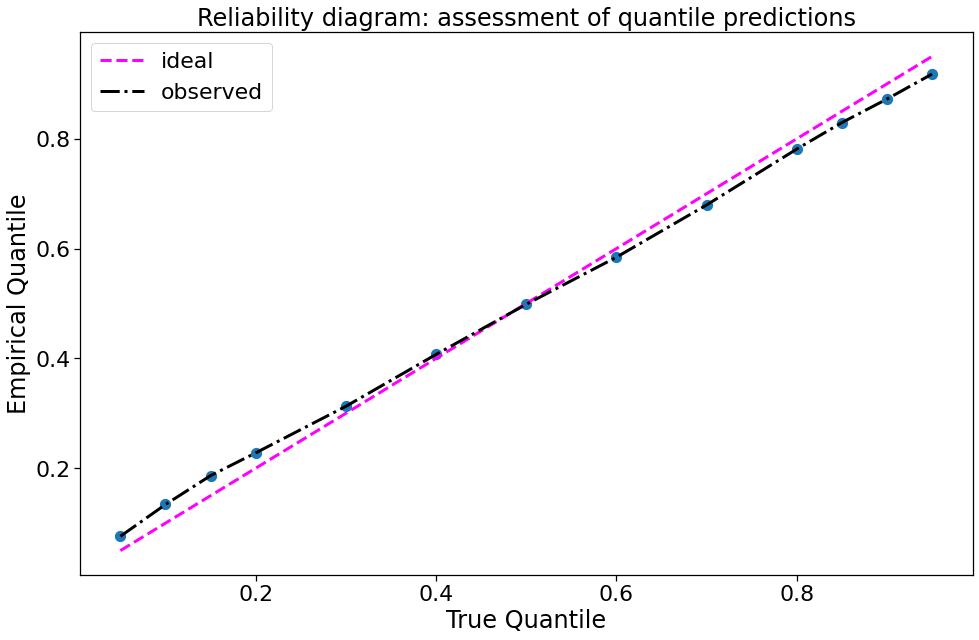

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
sns.set_context("notebook", font_scale=2)
sns.lineplot(x = quantiles, y = quantiles, color = "magenta", linestyle='--', linewidth=3, label = "ideal")
sns.lineplot(x = quantiles, y = empirical_quantiles, color = "black", linestyle = "dashdot", linewidth=3, label = "observed")
sns.scatterplot(x = quantiles, y = empirical_quantiles, marker="o", s = 150)
plt.legend()
plt.xlabel("True Quantile")
plt.ylabel("Empirical Quantile")
_ = plt.title("Reliability diagram: assessment of quantile predictions")

### Sharpness / Interval Length

Perfect probabilistic predictions should estimate 100% of the probability for a single value. In reality, a conditional distribution will allocate different probabilities for each possible outcome. Sharpness is a measure of how tight the predictive densities are. The narrower the interval length is, the more confident we can be about the prediction.

![](https://miro.medium.com/max/630/1*Zg4dnO-QShN86vpeDInB-A.png)

![](https://miro.medium.com/max/630/1*nXJCFEeGKQ2l1j6vKyEZwg.png)

As the interval increases, the proportion of missing observations decreases but as we can see, LightGBM Quantile Regression has the highest number of biased observations followed by NGBoost.

### Negative Log Likelihood (NLL)

The likelihood function describes the joint probability of the observed data as a function of the parameters of the chosen statistical model. 

This metric is suitable for algorithms that generate conditional probability distributions. Both NGBoost and Regression Neural Network are also using NLL as the loss function. 

NLL of the normal distribution is defined as the negative log of the probability density function of the normal distribution:

![](https://miro.medium.com/max/630/1*uqszUelouR175CP94ZcBSA.png)


The NLL is being evaluated at each observation using the parameters of the (normal) distribution. To compare NLL between algorithms we average NLLs across all observations. The lower the (average) NLL is the better the fit.

Here is the visual comparison of predictive distributions of the first observation and its corresponding NLL for Regression Neural Network and NGBoost:

![](https://miro.medium.com/max/630/1*FQyMhOSRxkPCl1K_Y72lOA.png)


NLL for NGBoost can be calculated in several ways:

NGBoost provides the function pred_dist that returns an object, which provides a logpdf function that calculates a log-likelihood for each observation. To get the NLL just negate the results. The final NLL is the average of individual NLLs

In [17]:
ngb_dist_pred = ngb.pred_dist(X_test)
nll_ngboost = -ngb_dist_pred.logpdf(y_test)
nll_ngboost.mean()

0.7016896460481001

In [18]:
ngb_dist_pred[0].params

{'loc': 0.6675750900516725, 'scale': 0.38128804876082506}

In [19]:
ngb_dist_pred.params

{'loc': array([0.66757509, 1.07930075, 3.86083596, ..., 4.59621213, 1.00234074,
        1.93741837]),
 'scale': array([0.38128805, 0.44117712, 1.15064006, ..., 0.59316368, 0.45316121,
        0.4060272 ])}

For Regression Neural Networks we iterate through all observations and their corresponding distribution parameters:

In [20]:
from scipy import stats

#extract mean predictions
dl_mean_prediction = model_mean.predict(X_test_scaled).reshape(-1)
#extract standard deviations
dl_sd_prediction = model_sd.predict(X_test_scaled).reshape(-1)
#iterate over all observations
nll_dl = []
for (true_mean, mean_temp, sd_temp) in zip(y_test, 
                                           dl_mean_prediction,
                                           dl_sd_prediction):
    nll_temp = -stats.norm.logpdf(true_mean, 
                                  loc = mean_temp, 
                                  scale = sd_temp)
    nll_dl.append(nll_temp)

129/129 [==============================] - 1s 6ms/step


In [22]:
import numpy as np

np.mean(nll_dl)

0.8705683416561047

In terms of NLL, NGBoost got a lower value (-4.888) than Regression Neural Network (-1.566) so we can conclude that NGBoost has a better fit.

### Continuous Ranked Probability Score

The Continuous Ranked Probability Score, known as CRPS, is a score to measure how a proposed distribution approximates the data, without knowledge about the true distributions of the data. 

In [24]:
#Computes the CRPS of observations x relative to normally distributed with mean, mu, and standard deviation, sig.
import properscoring as ps
crps_ngboost = ps.crps_gaussian(y_test, 
                               ngb_dist_pred.params["loc"],
                               ngb_dist_pred.params["scale"]).mean()
crps_dl = ps.crps_gaussian(y_test, 
                           dl_mean_prediction,  
                           dl_sd_prediction).mean()
(crps_ngboost, crps_dl)

(0.2856995647086271, 0.33292387071684504)

NGBoost has far smaller CRPS than Regression Neural Network which again suggests that NGBoost has a better fit.